# CellNet

In [1]:


from math import prod
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import torch
from torch.utils.data import DataLoader

import albumentations as A
from albumentations.pytorch import ToTensorV2

from collections import defaultdict 
from types import SimpleNamespace as obj
import itertools as it

import util.data as data
import util.plot as plot

CUDA = torch.cuda.is_available()
device = torch.device('cuda:0' if CUDA else 'cpu')

DRAFT = not CUDA
if DRAFT: plot.set_zoom(0.25)

def gpu(x, device=device): return torch.from_numpy(x).float().to(device)
def cpu(x): return x.detach().cpu().numpy() if isinstance(x, torch.Tensor) else x

key2text = {'tl': 'Training Loss',     'vl': 'Validation Loss', 
            'ta': 'Training Accuracy', 'va': 'Validation Accuracy', 
            'ti': 'Training ImageIDs', 'vi': 'Validation ImageIDs',
            'f' : 'Fraction of Data',  's' : 'Artificial Sparsity',
            'e' : 'Epoch', 'lr': 'Learning Rate' }

In [2]:
cfg = obj(
  sigma = 5,
  maxdist = 26,
  cropsize = 256,
  label2int = lambda l:{'Live Cell':1, 'Dead cell/debris':2}[l], 
)

def batched(f):
  def inner(B):
    n_masks = len(B['masks'])
    R= torch.stack([f(
          image=b[0], masks=[b[m] for m in range(1,n_masks+1)], keypoints=b[n_masks+1], class_labels=b[n_masks+2]
        ) for b in zip(B['image'], *B['masks'], B['keypoints'], B['class_labels'])
      ], dim=0)
    return R
  return inner

def mkDataset(ids, **dataset_kwargs): return data.CellnetDataset(ids, **dataset_kwargs, **cfg.__dict__)  

def mkNorms(norm_using_images = [1,2,4]):
  ds = mkDataset(norm_using_images)
  XNorm = lambda **kw: A.Normalize(mean=ds.X.mean(axis=(0,1,2))/255, 
                                    std=ds.X.std (axis=(0,1,2))/255, **kw)

  Y = np.stack([data.Keypoints2Heatmap(cfg.sigma, 0, 1, labels_to_include=[1])(x.transpose(2,0,1),[m],p,l) for x,m,p,l in zip(ds.X, ds.M, ds.P, ds.L)], axis=0)
  ymean, ystd = Y.mean(axis=(0,2,3)), Y.std(axis=(0,2,3))
  keypoints2heatmap = data.Keypoints2Heatmap(cfg.sigma, ymean, ystd, labels_to_include=[1])


  #ymean, ystd = [torch.from_numpy(v.astype(np.float32)).to(device) for v in (ymean, ystd)]
  yunnorm = lambda y: y*ystd.item() + ymean.item()
  return XNorm, keypoints2heatmap, yunnorm

XNorm, keypoints2heatmap, yunnorm = mkNorms()

def mkAugs(mode):
  kpp = A.KeypointParams(format='xy', label_fields=['class_labels'], remove_invisible=True)

  test = A.Compose(transforms=[
    A.PadIfNeeded(cfg.cropsize*2, cfg.cropsize*2, border_mode=0, value=0),
    A.ToFloat(),
    #XNorm(),  #NOTE TODO fix (also below)
    ToTensorV2(transpose_mask=True, always_apply=True)], 
    keypoint_params=kpp)

  aug = A.Compose([
      *([A.PadIfNeeded(cfg.cropsize, cfg.cropsize, border_mode=0, value=0),
         A.RandomCrop(cfg.cropsize, cfg.cropsize, p=1),
         ]
      if mode=='val' else [
        A.PadIfNeeded(cfg.cropsize*2, cfg.cropsize*2, border_mode=0, value=0),
        A.RandomSizedCrop(p=1, min_max_height=(cfg.cropsize//2, cfg.cropsize*2), 
                          height=cfg.cropsize, width=cfg.cropsize),

        # spatial with keypoints
        A.CoarseDropout(max_height=cfg.cropsize//3, max_width=cfg.cropsize//3,
                        min_height=cfg.cropsize//20,min_width=cfg.cropsize//20),  # evolution of CutOut and RandomErasing
        #A.Perspective(),  
        A.Rotate(),
        #A.RandomGridShuffle(), 

        # spatial no keypoints
        ## A.ElasticTransform(), 
        ## A.GridDistortion(),  
        ## A.GridDropout(),  # redundant with Dropout
        ## A.OpticalDistortion(),  
        
        # blur
        A.AdvancedBlur(),
        # TODO - blur colorchannels like different focal planes

        # color
        A.Equalize(),
        A.ColorJitter(), 
        A.ChannelDropout(),  # too much color?
        A.ChannelShuffle(),  
        # A.ChromaticAberration(), # NEEDS python 3.11 - but cannot because of onnxruntime needing old modle

        # noise
        A.GaussNoise(),
      ]), 

    # TODO D4
    A.ToFloat(),
    #XNorm(), 
    ToTensorV2(transpose_mask=True, always_apply=True), 
    ], keypoint_params=kpp)

  return test if mode=='test' else aug
  

trainaugs = mkAugs('train')
valaugs = mkAugs('val')
testaugs = mkAugs('test')

def debug_collate(S):
  return dict(
    image = torch.stack([s['image'] for s in S]),
    masks = [torch.stack([s['masks'][i] for s in S]) for i in range(len(S[0]['masks']))],
    keypoints = [s['keypoints'] for s in S],
    class_labels = [s['class_labels'] for s in S],
  )

def mkLoader(ids, bs, transforms, fraction=1.0, sparsity=1.0, shuffle=True):
  from torch.cuda import device_count as gpu_count; from multiprocessing import cpu_count 
  return DataLoader(mkDataset(ids, transforms=transforms, fraction=fraction, sparsity=sparsity, batch_size=bs), 
    batch_size=bs, shuffle=shuffle, collate_fn= debug_collate,
    persistent_workers=True, pin_memory=True, num_workers = max(1, (cpu_count()//6) // max(1,gpu_count())))

/gpfs/space/home/eckhardt/.micromamba/envs/cellnet/lib/python3.12/site-packages/onnxruntime/capi/onnxruntime_inference_collection.py:69: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'CPUExecutionProvider'
  warnings.warn(


/gpfs/space/home/eckhardt/.micromamba/envs/cellnet/lib/python3.12/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


/gpfs/space/home/eckhardt/.micromamba/envs/cellnet/lib/python3.12/site-packages/IPython/core/events.py:82: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  func(*args, **kwargs)


/gpfs/space/home/eckhardt/.micromamba/envs/cellnet/lib/python3.12/site-packages/IPython/core/pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


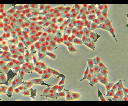

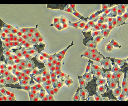

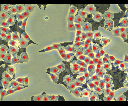

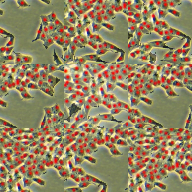

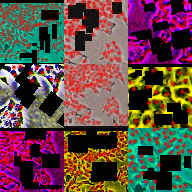

In [3]:

def plot_overlay(x,m,z, ax=None):
  ax_was_none = ax==None
  ax = plot.image(x, ax=ax)
  plot.heatmap(m, ax=ax, alpha=lambda x: 0.5*x, color='#000000')
  plot.heatmap(z, ax=ax, alpha=lambda x: 1.0*x, color='#ff0000')
  if ax_was_none: pass# plt.close('all')


def plot_grid(grid, **loader_kwargs):
  loader = mkLoader([1], bs=prod(grid), fraction = 0.3 if DRAFT else 1.0, **loader_kwargs)
  B = next(iter(loader))
  B = zip(B['image'], B['masks'][0], batched(keypoints2heatmap)(B))
  for b,ax in zip(B, plot.grid(grid, [cfg.cropsize]*2)[1]):
    plot_overlay(*[cpu(v) for v in b], ax=ax)
  pass# plt.close('all')

for B in mkLoader([1,2,4], bs=1, fraction = 0.3 if DRAFT else 1.0, transforms=testaugs, shuffle=False):
  plot_overlay(*[cpu(v[0]) for v in [B['image'], B['masks'][0], batched(keypoints2heatmap)(B)]])

plot_grid((3,3), transforms=valaugs)
plot_grid((3,3), transforms=trainaugs)

In [4]:
import segmentation_models_pytorch as smp

mk_model = lambda: smp.Unet(  # NOTE TODO: check if spefically used model automatically mirror pads in training or inference
    encoder_name="resnet34" if not DRAFT else "resnet18",  # 18 34 101
    encoder_weights=None,
    in_channels=3,
    classes=1,
    activation=None,
  ).to(device)  
mk_model()

/gpfs/space/home/eckhardt/.micromamba/envs/cellnet/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

/gpfs/space/home/eckhardt/.micromamba/envs/cellnet/lib/python3.12/site-packages/onnxruntime/capi/onnxruntime_inference_collection.py:69: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'CPUExecutionProvider'
  warnings.warn(


/gpfs/space/home/eckhardt/.micromamba/envs/cellnet/lib/python3.12/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


/gpfs/space/home/eckhardt/.micromamba/envs/cellnet/lib/python3.12/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


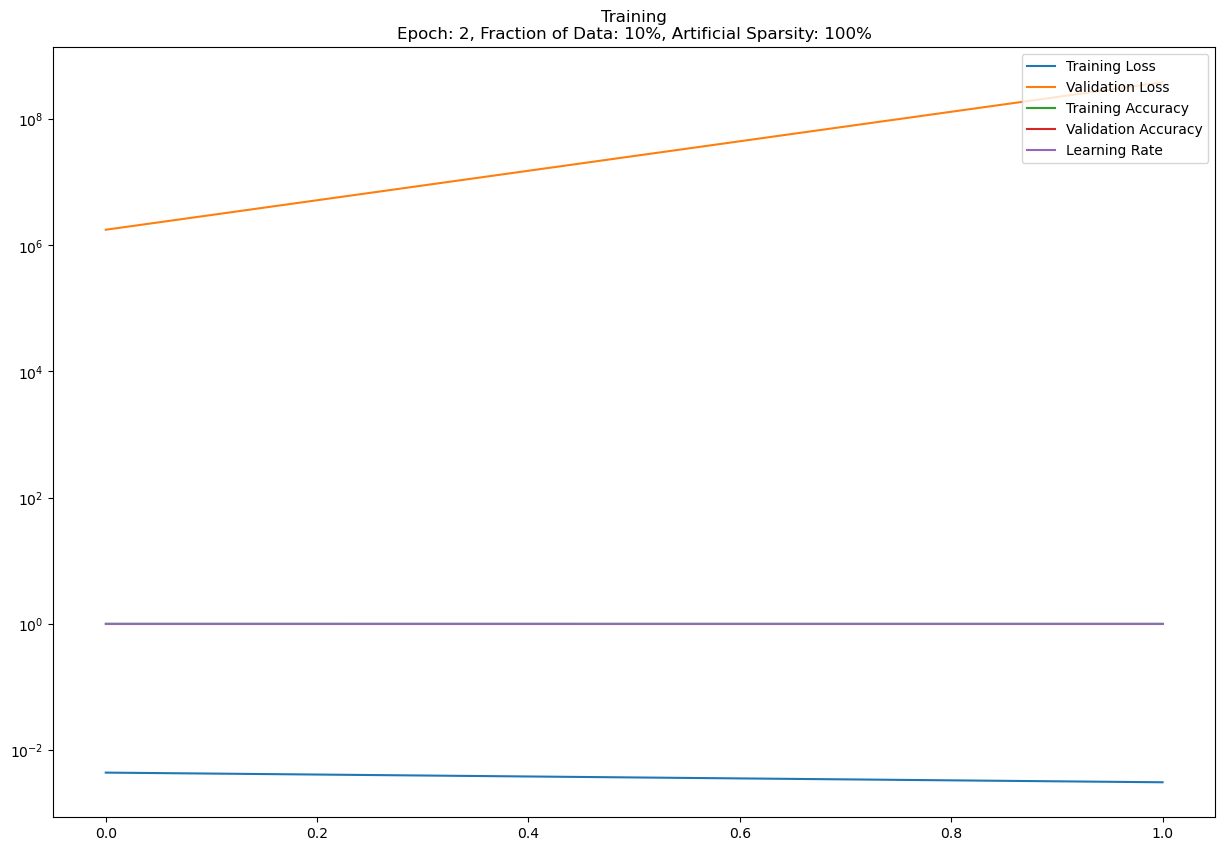

/tmp/ipykernel_122468/3446537212.py:152: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, pd.DataFrame(dict(**log.iloc[-1],


In [5]:

# TODO: apply MESA loss from lempitsky2010learning.  Other losses: research follow-up literature. (xie2016microscopy uses L2 loss)
def lossf(y, z, m, count=False):
  y *= m; z *= m  # mask 
  SE = (y - z)**2 
  MSE = SE.mean()

  C = (y.sum() - z.sum()) / z.sum()   # TODO opt-in count loss, later in training? normalize with respect to MSE? because rn it seems to disturb training?
  
  return MSE + (C if count else 0)

def accuracy(y,z, return_counts=False):
  ny = yunnorm(y).sum().item()
  nz = yunnorm(z).sum().item()
  a = 1 - abs(ny - nz) / nz
  if return_counts: return ny, nz, a
  else: return a

def train(epochs, model, traindl, valdl=None, plot_live = False, info={}):
  lr0 = 5e-3
  optim = torch.optim.Adam(model.parameters(), lr=lr0)
  sched = torch.optim.lr_scheduler.StepLR(optim, step_size=80, gamma=0.1)

  log = pd.DataFrame(columns='tl vl ta va lr'.split(' '), index=range(epochs))
  for e in range(epochs):
    model.train()

    l = 0; a = 0; b = 0
    for b, B in enumerate(traindl):
      # NOTE: despite batchsize > 3, we can only sample <=3 images, as long as the dataset is not circular (todo: make it circular)
      x,m = B['image'].to(device), B['masks'][0].to(device)
      z = batched(keypoints2heatmap)(B).to(device).unsqueeze(0)

      y = model(x)
      loss = lossf(y,z,m)
      loss.backward()
      optim.step()
      optim.zero_grad()

      l += loss.item()
      a += accuracy(y,z) # type: ignore

    lg = log.loc[e] 
    lg['tl'] = l/(b+1)
    lg['ta'] = a/(b+1)
    lg['lr'] = optim.param_groups[0]['lr']/lr0

    sched.step()  # LATER

    if valdl is not None:
      model.eval()
      with torch.no_grad():
        l = 0; a = 0
        for b, B in enumerate(valdl):
          x,m = B['image'].to(device), B['masks'][0].to(device)
          z = batched(keypoints2heatmap)(B).to(device).unsqueeze(0)

          y = model(x)

          l += lossf(y,z,m).item()
          a += accuracy(y,z) # type: ignore
        
        lg['vl'] = l/(b+1)
        lg['va'] = a/(b+1)

    if plot_live: plot.train_graph(e, log, info=info, key2text=key2text, clear=True)
  plot.train_graph(epochs, log, info=info, key2text=key2text)  # TODO combine all train graphs into one 
  
  return log


def do(ti, vi, f, s):
  traindl = mkLoader(ti, 8, transforms=trainaugs, fraction=f, sparsity=s)
  valdl   = mkLoader(vi, 1, transforms=valaugs)

  model = mk_model()
  log = train(100 if not DRAFT else 2, model, traindl, valdl, 
              info={'f': f'{f:.0%}', 's': f'{s:.0%}'})
  
  return log, model
  

results = pd.DataFrame(columns=['m', 'f', 's', 'ti', 'vi', 'ta', 'va', 'tl', 'vl'])


runs = [
  ([2,4], [1], 1, 1),
  ([1,4], [2], 1, 1),
  ([1,2], [4], 1, 1),

  ([2,4], [1], 0.75, 1),
  ([1,4], [2], 0.75, 1),
  ([1,2], [4], 0.75, 1),
  
  ([2,4], [1], 0.5, 1),
  ([1,4], [2], 0.5, 1),
  ([1,2], [4], 0.5, 1),
  
  ([2,4], [1], 0.25, 1),
  ([1,4], [2], 0.25, 1),
  ([1,2], [4], 0.25, 1),
  
  ([2,4], [1], 0.1, 1),
  ([1,4], [2], 0.1, 1),
  ([1,2], [4], 0.1, 1),
  
  ([2,4], [1], 0.05, 1),
  ([1,4], [2], 0.05, 1),  
  ([1,2], [4], 0.05, 1),
  
  ([2,4], [1], 0.01, 1),
  ([1,4], [2], 0.01, 1),
  ([1,2], [4], 0.01, 1),


  # Credit Kaupo: extrapolate sparsity's effect
  ([2,4], [1], 1, 0.75),
  ([1,4], [2], 1, 0.75),
  ([1,2], [4], 1, 0.75),

  ([2,4], [1], 1, 0.5),
  ([1,4], [2], 1, 0.5),
  ([1,2], [4], 1, 0.5),

  ([2,4], [1], 1, 0.25),
  ([1,4], [2], 1, 0.25),
  ([1,2], [4], 1, 0.25),

  ([2,4], [1], 1, 0.1),
  ([1,4], [2], 1, 0.1),
  ([1,2], [4], 1, 0.1),

  ([2,4], [1], 1, 0.05),
  ([1,4], [2], 1, 0.05),
  ([1,2], [4], 1, 0.05),

  ([2,4], [1], 1, 0.01),
  ([1,4], [2], 1, 0.01),
  ([1,2], [4], 1, 0.01),
] if not DRAFT else \
  [([1],[1],0.1,1)]

# Overwrite for test run
runs = [
  ([2,4], [1], 1, 1),
  ([2,4], [1], 0.1, 1),
  ([2,4], [1], 1, 0.1),
] if not DRAFT else \
  [([1],[1],0.1,1)]

for ti, vi, f, s in runs:
  log, model = do(ti, vi, f, s)
  results = pd.concat([results, pd.DataFrame(dict(**log.iloc[-1],
        m = model if f*s==1 or DRAFT else None, ti = ti, vi = vi, f = f, s = s))], 
        ignore_index=True)
  
# save the results as csv. exclude model column
import os; os.makedirs('results/cellnet', exist_ok=True)
results.drop(columns=['m']).to_csv('results/cellnet/results.csv', index=False)

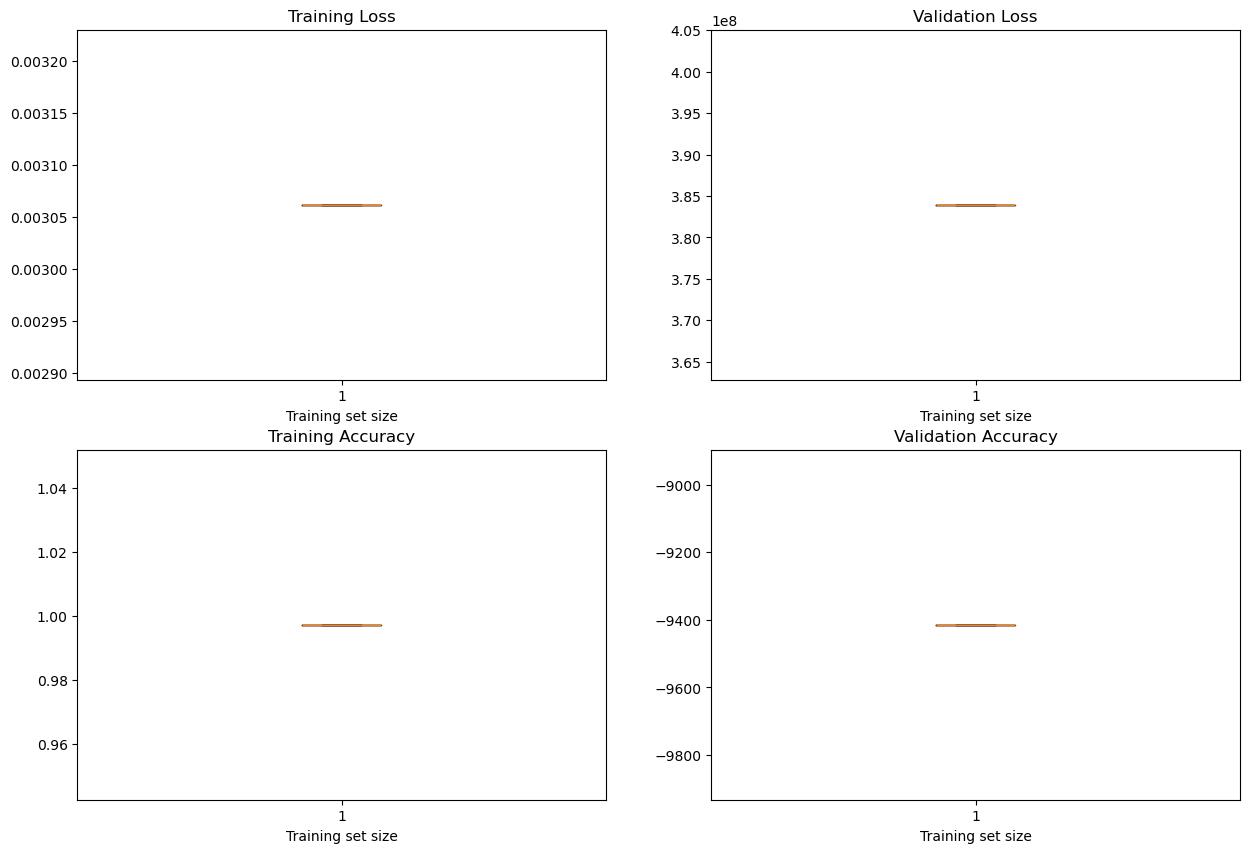

In [6]:
fig, axs = plt.subplots(2,2, figsize=(15,10))

for ax, (key, text) in zip(axs.flat, key2text.items()):
  if key in "ta va tl vl".split(' '):
    ax.boxplot(results[key].T)
    ax.set_title(text)
    ax.set_xlabel("Training set size")

/gpfs/space/home/eckhardt/.micromamba/envs/cellnet/lib/python3.12/site-packages/onnxruntime/capi/onnxruntime_inference_collection.py:69: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'CPUExecutionProvider'
  warnings.warn(


/gpfs/space/home/eckhardt/.micromamba/envs/cellnet/lib/python3.12/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Model 0 :  -413566656.0 / 1751.467041015625 23612585%


/gpfs/space/home/eckhardt/.micromamba/envs/cellnet/lib/python3.12/site-packages/IPython/core/events.py:82: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  func(*args, **kwargs)


/gpfs/space/home/eckhardt/.micromamba/envs/cellnet/lib/python3.12/site-packages/IPython/core/pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


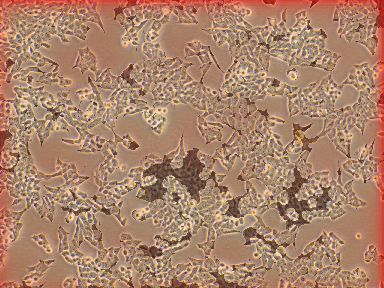

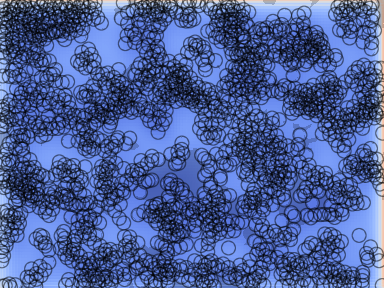

In [7]:

def plot_diff(x,m,y,z,k, ax=None):
  title = f"Difference between Target and Predicted Heatmap"
  ax = plot.image(yunnorm(y)-yunnorm(z), ax=ax, cmap='coolwarm')
  plot.heatmap(m, ax=ax, alpha=lambda x: 0.2*x, color='#000000')
  ax.scatter(*zip(*k), facecolors='none', edgecolors='black', marker='o', alpha=0.5, linewidths=10*100, s=np.pi*cfg.sigma**2*100)

def plot_predictions():
  for mi, m in enumerate(results.m.dropna()):
    m.eval()
    #loader = mkLoader([1,2,4], 1, transforms=testaugs, shuffle=False)
    loader = mkLoader([1], 1, transforms=testaugs, shuffle=False)

    def do(m, batch):
      B = batch['image'], batch['masks'][0], m(batch['image'].to(device)), batched(keypoints2heatmap)(batch), batch['keypoints']
      
      for x,m,y,z,k in zip(*[cpu(v) for v in B]):
        plot_overlay(x,m,y)
        plot_diff(x,m,y,z,k)
        
        #plot.image(np.zeros((100,10,3)))  # separator

        ny,nz,a = accuracy(y,z, return_counts=True)
        print('Model', mi, ': ', ny, '/', nz, f"{int(100*abs(a))}%")  # TODO replace with accuracy function if same

    for batch in loader:
      do(m, batch)

plot_predictions()

In [8]:
plt.close('all')